<a href="https://colab.research.google.com/github/MhmdFasihi/Complete-Python-3-Bootcamp/blob/master/Black_Litterman_Allocation_Crypto_Related_Views.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Black-Litterman Allocation for Cryptocurrencies

## Introduction

This notebook demonstrates the application of the Black-Litterman model to a cryptocurrency portfolio. The Black-Litterman model is an advanced portfolio construction technique that combines market equilibrium returns with investor views to create a more robust portfolio allocation.


# Install necessary libraries


In [ ]:
! pip install numpy pandas matplotlib yfinance PyPortfolioOpt seaborn

## Setup and Data Collection

First, we'll import the necessary libraries and download our cryptocurrency data.


In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pypfopt import black_litterman, risk_models, BlackLittermanModel, plotting, EfficientFrontier, objective_functions, DiscreteAllocation
import seaborn as sns

In [131]:
# Define cryptocurrency tickers
tickers = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'XRP-USD']

In [132]:
# Download historical price data
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%%**********************]  5 of 5 completed


Ticker,BNB-USD,BTC-USD,ETH-USD,SOL-USD,XRP-USD
Date,,,,,
2024-07-03,556.577759,60173.921875,3292.916748,140.731415,0.466760
2024-07-04,513.994507,56977.703125,3054.521973,127.550819,0.433574
2024-07-05,497.995819,56662.375000,2981.598633,134.369339,0.425492
2024-07-06,527.674377,58303.539062,3069.377930,143.241180,0.449053
2024-07-07,509.206726,57546.644531,3021.761719,140.340332,0.435584


In [133]:
# Download market (Bitcoin) prices
market_prices = yf.download("BTC-USD", period="max")["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Adj Close, dtype: float64

In [134]:
# Fetch market caps (note: this method might not be reliable for all cryptocurrencies)
mcaps = {}
for t in tickers:
    crypto = yf.Ticker(t)
    mcaps[t] = crypto.info.get("marketCap")
print(mcaps)

{'BTC-USD': 1134739718144, 'ETH-USD': 363234885632, 'BNB-USD': 75166244864, 'SOL-USD': 65043296256, 'XRP-USD': 24272898048}


# Covariance Matrix and Risk Aversion
Next, we'll calculate the covariance matrix and market-implied risk aversion.

In [136]:
# Calculate the covariance matrix
S = risk_models.CovarianceShrinkage(prices, frequency=364, log_returns=True).ledoit_wolf()

# Calculate the market-implied risk aversion
delta = black_litterman.market_implied_risk_aversion(market_prices, frequency=364, risk_free_rate=0.05)
print(f"Market-implied risk aversion: {delta}")

Market-implied risk aversion: 1.4106695041020918


<Axes: >

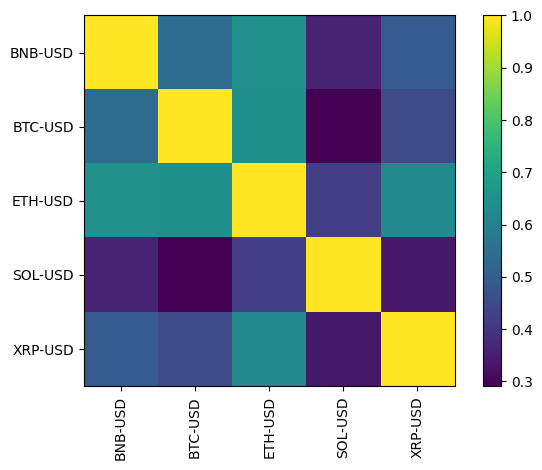

In [137]:
# Plot the covariance matrix
plotting.plot_covariance(S, plot_correlation=True)

# Explanation:

* **S**:This is the covariance matrix of asset returns, estimated using the Ledoit-Wolf shrinkage method.
* **delta**:This represents the market's risk aversion, derived from historical market returns.
* **frequency**=364:We use 364 days for annual calculations because crypto markets trade 24/7,closing only on January 1st.\
Default is 252.
* **risk_free_rate**=0.05:This is set to 5% as an example. In practice, you should use a current risk-free rate.
Default is 2%.

###Note:
The risk-free rate in the crypto market is a contentious topic. Unlike traditional markets, there's no universally accepted "risk-free" asset in crypto. Some practitioners use the yield on stablecoins or DeFi lending rates as a proxy, while others use traditional risk-free rates like U.S. Treasury yields. The choice depends on your investment perspective and risk assessment.
To use an up-to-date risk-free rate, you could fetch it programmatically from a reliable financial data API or manually input a current value.

#Market-Implied Returns
We'll now calculate the market-implied returns.

In [138]:
# Calculate the market-implied prior returns
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S, risk_free_rate=0.05)
print("Market-implied prior returns:")
print(market_prior)

Market-implied prior returns:
Ticker
BNB-USD    0.547906
BTC-USD    0.669496
ETH-USD    0.593876
SOL-USD    0.371325
XRP-USD    0.525370
dtype: float64


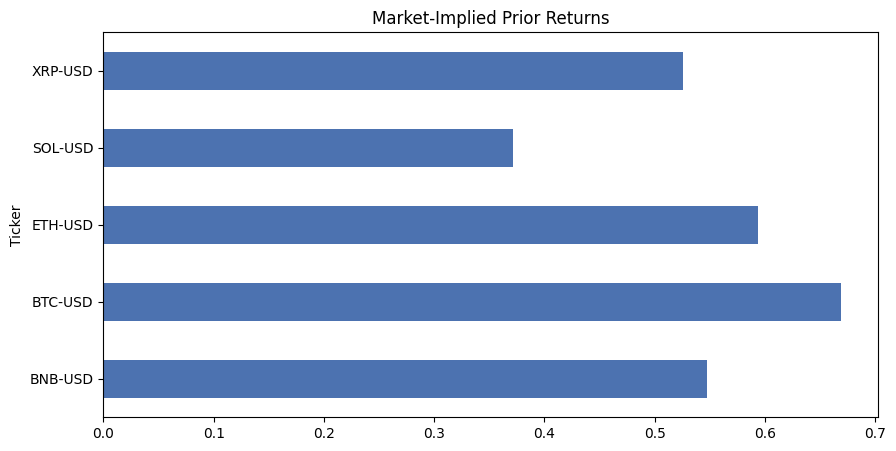

In [139]:
# Plot the market-implied prior returns
market_prior.plot.barh(figsize=(10,5))
plt.title("Market-Implied Prior Returns")
plt.show()

#Explanation:


*   **market_prior**: These are the expected returns implied by market capitalization weights, assuming the market is in equilibrium.




# Investor Views
Next, we'll specify our views on the market.

In [140]:
# Define views using Q and P matrices
Q = np.array([0.05, 0.2, 0.1, 0.05, -0.05]).reshape(-1, 1)
P = np.array([
    [1, 0, 0, 0, 0],    # BNB will grow 5%
    [0, 1, 0, 0, 0],    # BTC will grow 20%
    [0, -1, 1, 0, 0],   # ETH will outperform BTC by 10%
    [-1, 0, 0, 1, 0],   # SOL will outperform BNB by 5%
    [0, 0, 0, 0, 1]     # XRP will decrease 5%
])

# Define view confidences
confidences = [0.6, 0.4, 0.2, 0.4, 0.5]

# Explanation:

* **Q**: This vector represents the expected returns for each view.
* **P**: This matrix maps the views to specific assets or combinations of assets.
* **confidences**: This list represents our confidence in each view.

# Black-Litterman Model
Now we'll create and analyze the Black-Litterman model.

In [141]:
# Create Black-Litterman model
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                         Q=Q, P=P, omega="idzorek", view_confidences=confidences,
                         risk_free_rate=0.05)

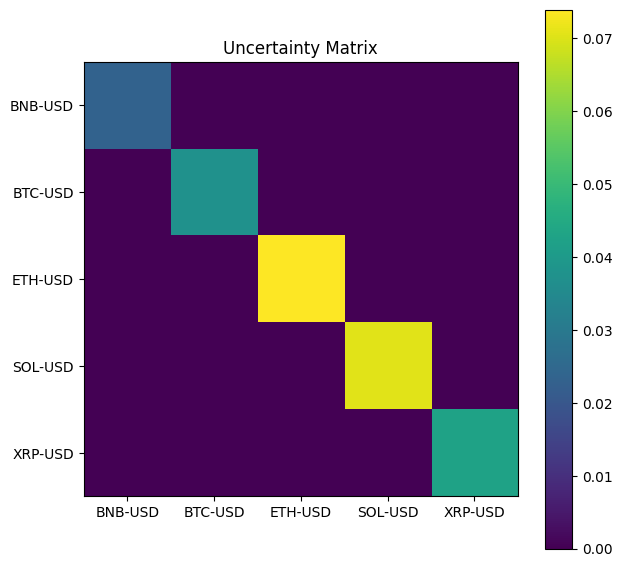

In [142]:
# Plot the uncertainty matrix
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))
ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.title("Uncertainty Matrix")
plt.colorbar(im)
plt.show()

In [143]:
# Print the diagonal of the uncertainty matrix
print("Diagonal of the uncertainty matrix:")
print(np.diag(bl.omega))

Diagonal of the uncertainty matrix:
[0.02327317 0.0373074  0.07393954 0.07054014 0.04264567]


In [144]:
# Calculate posterior estimates
ret_bl = bl.bl_returns()
S_bl = bl.bl_cov()

In [145]:
# Compare prior, posterior, and views
rets_df = pd.DataFrame({
    "Prior": market_prior,
    "Posterior": ret_bl,
    "Views": pd.Series(Q.flatten(), index=bl.tickers, name="Views")
})

print("Comparison of Prior, Posterior, and Views:")
print(rets_df)

Comparison of Prior, Posterior, and Views:
            Prior  Posterior  Views
Ticker                             
BNB-USD  0.547906   0.183317   0.05
BTC-USD  0.669496   0.372597   0.20
ETH-USD  0.593876   0.317117   0.10
SOL-USD  0.371325   0.208418   0.05
XRP-USD  0.525370   0.154691  -0.05


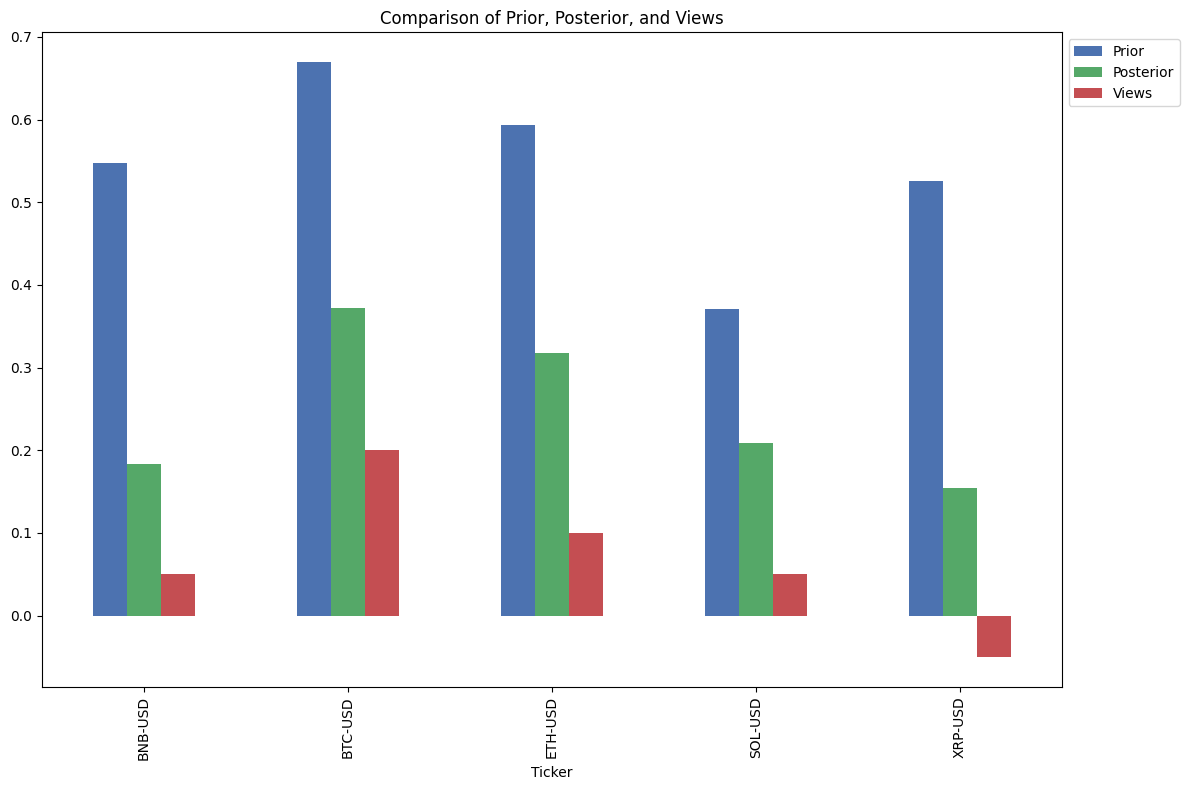

In [146]:
# Plot the comparison
rets_df.plot.bar(figsize=(12,8))
plt.title("Comparison of Prior, Posterior, and Views")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

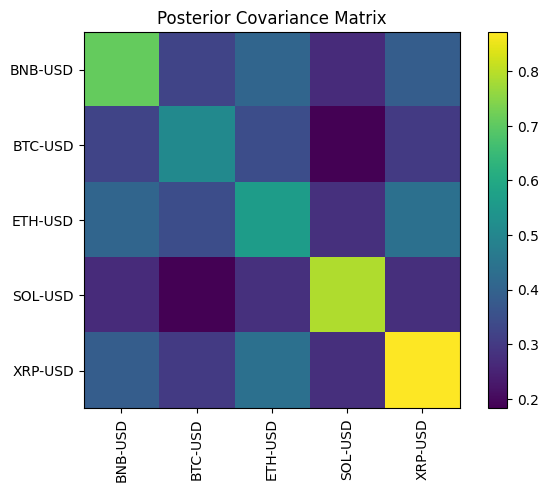

In [147]:
# Plot the posterior covariance matrix
plotting.plot_covariance(S_bl)
plt.title("Posterior Covariance Matrix")
plt.show()

# Explanation:

* **bl**: This is our Black-Litterman model, combining market data with our views.
* **bl.omega**: This is the uncertainty matrix, representing the uncertainty in our views.
* **ret_bl**: These are the posterior expected returns after incorporating our views.
* **S_bl**: This is the posterior covariance matrix.

## Portfolio Optimization
Finally, we'll optimize our portfolio based on the Black-Litterman results.

In [152]:
# Portfolio optimization
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe(risk_free_rate=0.05)
weights = ef.clean_weights()
print("Optimal weights:")
print(weights)

# Calculate and print the sum of weights
weight_sum = sum(weights.values())
print(f"\nSum of weights: {weight_sum:.4f}")

Optimal weights:
OrderedDict([('BNB-USD', 0.02157), ('BTC-USD', 0.49973), ('ETH-USD', 0.33765), ('SOL-USD', 0.14104), ('XRP-USD', 0.0)])

Sum of weights: 1.0000


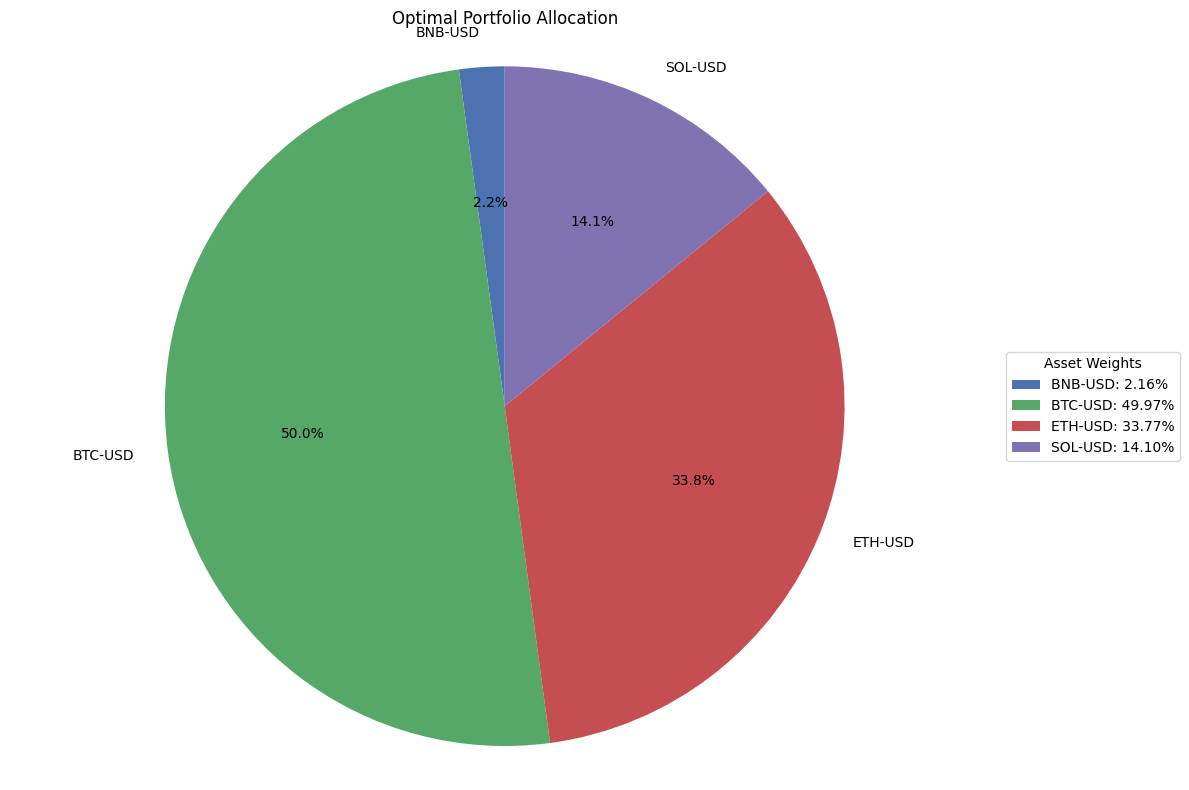

In [153]:
# Plot the optimal portfolio allocation
plt.figure(figsize=(12, 8))
weights_series = pd.Series(weights)
weights_series = weights_series[weights_series > 0]
plt.pie(weights_series.values, labels=weights_series.index, autopct='%1.1f%%', startangle=90)
plt.title("Optimal Portfolio Allocation")
legend_labels = [f'{asset}: {weight:.2%}' for asset, weight in weights_series.items()]
plt.legend(legend_labels, title="Asset Weights", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.tight_layout()
plt.show()

In [154]:
# Discrete allocation
latest_prices = prices.iloc[-1]
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print("\nDiscrete allocation:")
print(alloc)
print(f"Funds remaining: ${leftover:.2f}")


Discrete allocation:
{'BNB-USD': 4, 'ETH-USD': 3, 'SOL-USD': 27, 'XRP-USD': 7804}
Funds remaining: $1709.40


In [156]:
# Portfolio performance
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance(risk_free_rate=0.05)

print(f"\nExpected annual return: {expected_annual_return:.2%}")
print(f"Annual volatility: {annual_volatility:.2%}")
print(f"Sharpe ratio: {sharpe_ratio:.2f}")


Expected annual return: 32.66%
Annual volatility: 62.51%
Sharpe ratio: 0.44


In [157]:
# Asset-specific metrics
print("\nAsset expected returns (from Black-Litterman):")
for asset, ret in ret_bl.items():
    print(f"{asset}: {ret:.2%}")


Asset expected returns (from Black-Litterman):
BNB-USD: 18.33%
BTC-USD: 37.26%
ETH-USD: 31.71%
SOL-USD: 20.84%
XRP-USD: 15.47%


In [158]:
asset_volatilities = np.sqrt(np.diag(S_bl))
print("\nAsset volatilities:")
for asset, vol in zip(S_bl.index, asset_volatilities):
    print(f"{asset}: {vol:.2%}")


Asset volatilities:
BNB-USD: 84.27%
BTC-USD: 71.39%
ETH-USD: 75.04%
SOL-USD: 88.94%
XRP-USD: 93.38%


In [159]:
# Correlation matrix
correlation_matrix = S_bl.corr()
print("\nCorrelation matrix:")
print(correlation_matrix)


Correlation matrix:
Ticker    BNB-USD   BTC-USD   ETH-USD   SOL-USD   XRP-USD
Ticker                                                   
BNB-USD  1.000000  0.045776  0.307077 -0.423367  0.049897
BTC-USD  0.045776  1.000000  0.183414 -0.812906 -0.118658
ETH-USD  0.307077  0.183414  1.000000 -0.570671  0.411690
SOL-USD -0.423367 -0.812906 -0.570671  1.000000 -0.325597
XRP-USD  0.049897 -0.118658  0.411690 -0.325597  1.000000


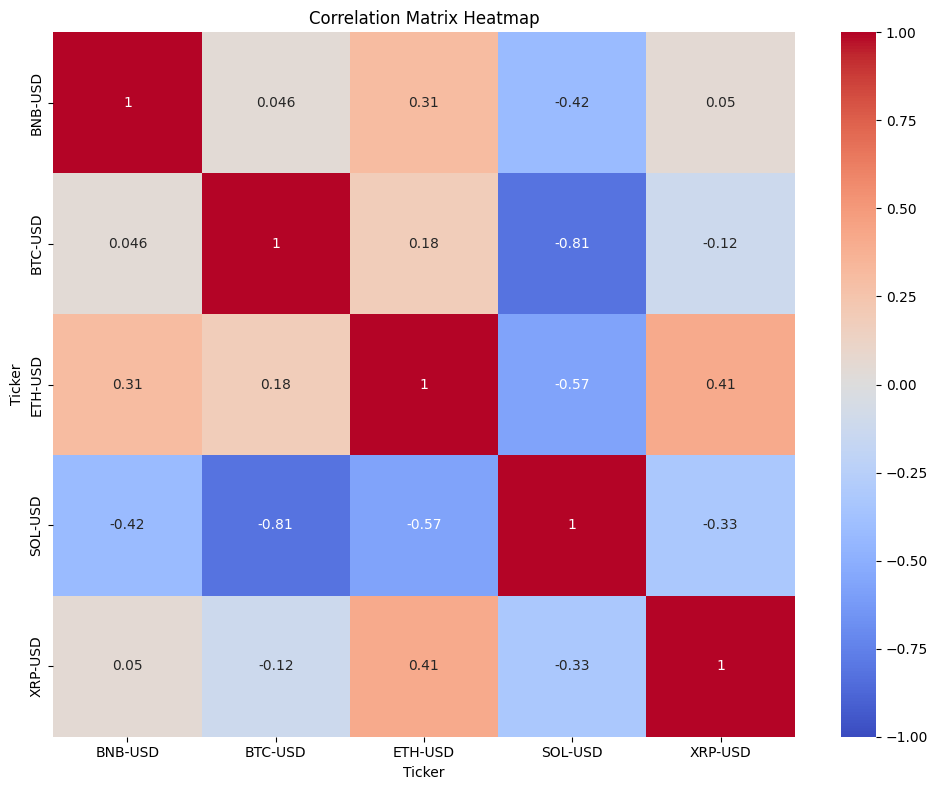

In [160]:
# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

# Explanation:

* We use the Efficient Frontier to find the optimal portfolio weights that maximize the Sharpe ratio.
* We perform discrete allocation to determine how many units of each asset to buy with a $20,000 portfolio.
* We calculate and display various portfolio and asset-specific metrics.
The correlation matrix heatmap visualizes the relationships between different assets in our portfolio.

This code provides a comprehensive analysis of a cryptocurrency portfolio using the Black-Litterman model. Remember that while this model is powerful, its results are highly dependent on the quality of inputs, especially in the volatile and rapidly evolving cryptocurrency market. Regular rebalancing and updating of views would be necessary in practice.